# Data investigation

In [1]:
!pip install transformers evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00a 0:00:01


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
DATA_ROOT = '/kaggle/input/sms-spam-collection-dataset/'
file_name = 'spam.csv'

In [4]:
dataframe = pd.read_csv(DATA_ROOT + file_name, encoding='latin-1')

In [5]:
dataframe = dataframe.loc[:, ~dataframe.columns.str.contains('^Unnamed')]
dataframe = dataframe.rename(columns = {'v1':'class', 'v2':'text'})
dataframe

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


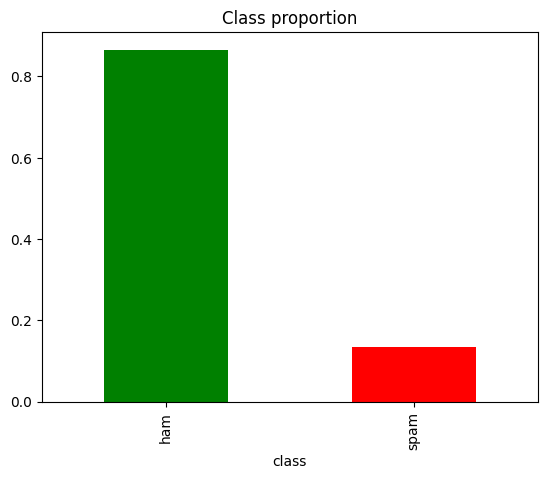

In [6]:
class_prop = dataframe['class'].value_counts(normalize=True, sort=True)
class_prop.plot(kind = 'bar',color = ["green","red"])
plt.title('Class proportion')
plt.show()
plt.close()

In [7]:
label2id = {
    'ham': 0,
    'spam': 1
}
dataframe['label'] = dataframe['class'].apply(lambda x: label2id[x])

# Data augmentation to balance classes

In [8]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 10.1 MB/s eta 0:00:0000:01


In [10]:
spam_list = dataframe['text'].loc[dataframe['class'] == 'spam'].to_list()
#spam_list

In [30]:
len(spam_list)

747

In [36]:
import nlpaug.augmenter.word as naw
import nlpaug.flow as naf

sometimes_delete = naf.Sometimes(
    naw.RandomWordAug(action="delete")
)
sometimes_insert = naf.Sometimes(
    naw.RandomWordAug(action="insert")
)
bert_aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-cased', action="substitute", aug_max=10
)
augment = naf.Sequential(
    sometimes_delete,
    sometimes_insert,
    bert_aug
)

In [35]:
from tqdm import tqdm
upsample_spam = list()
for el in tqdm(spam_list):
    output = augment.augment(el, n=4)
    upsample_spam.extend(output)

100%|██████████| 747/747 [00:00<00:00, 856.20it/s]


In [ ]:
upsample_spam

In [47]:
for el in tqdm(upsample_spam):
    new_row = {'class': 'spam', 'text': el, 'label': 1}
    #dataframe = dataframe.append(new_row)
    dataframe = pd.concat([dataframe, pd.DataFrame([new_row])])

100%|██████████| 2988/2988 [00:02<00:00, 1406.78it/s]


In [48]:
dataframe

,class,text,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
0,spam,REMINDER O2: To get 2. 50 free call credit and...,1
0,spam,Is the time we have 2 contact u. U the å 750 P...,1
0,spam,Is 2nd time we tried 2 contact u. U have won t...,1
0,spam,This is the 2nd time have tried 2 u. won å 750...,1


In [49]:
class_weights = (1 - dataframe['class'].value_counts(normalize=True, sort=True)).values
class_weights

array([0.43633178, 0.56366822])

In [50]:
cl_w_dict = {k: v for k, v in enumerate(class_weights)}

In [51]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight(class_weight = cl_w_dict, y = dataframe['label'].to_list())
sample_weight

array([0.43633178, 0.43633178, 0.56366822, ..., 0.56366822, 0.56366822,
       0.56366822])

In [52]:
dataframe['samp_weight'] = sample_weight

In [53]:
dataframe

,class,text,label,samp_weight
0,ham,"Go until jurong point, crazy.. Available only ...",0,0.436332
1,ham,Ok lar... Joking wif u oni...,0,0.436332
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,0.563668
3,ham,U dun say so early hor... U c already then say...,0,0.436332
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,0.436332
...,...,...,...,...
0,spam,REMINDER O2: To get 2. 50 free call credit and...,1,0.563668
0,spam,Is the time we have 2 contact u. U the å 750 P...,1,0.563668
0,spam,Is 2nd time we tried 2 contact u. U have won t...,1,0.563668
0,spam,This is the 2nd time have tried 2 u. won å 750...,1,0.563668


In [54]:
dataframe['text_length'] = dataframe['text'].apply(lambda x: len(x.split()))
dataframe.to_csv(path_or_buf='/kaggle/working/spam_fixed_augmented.csv')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


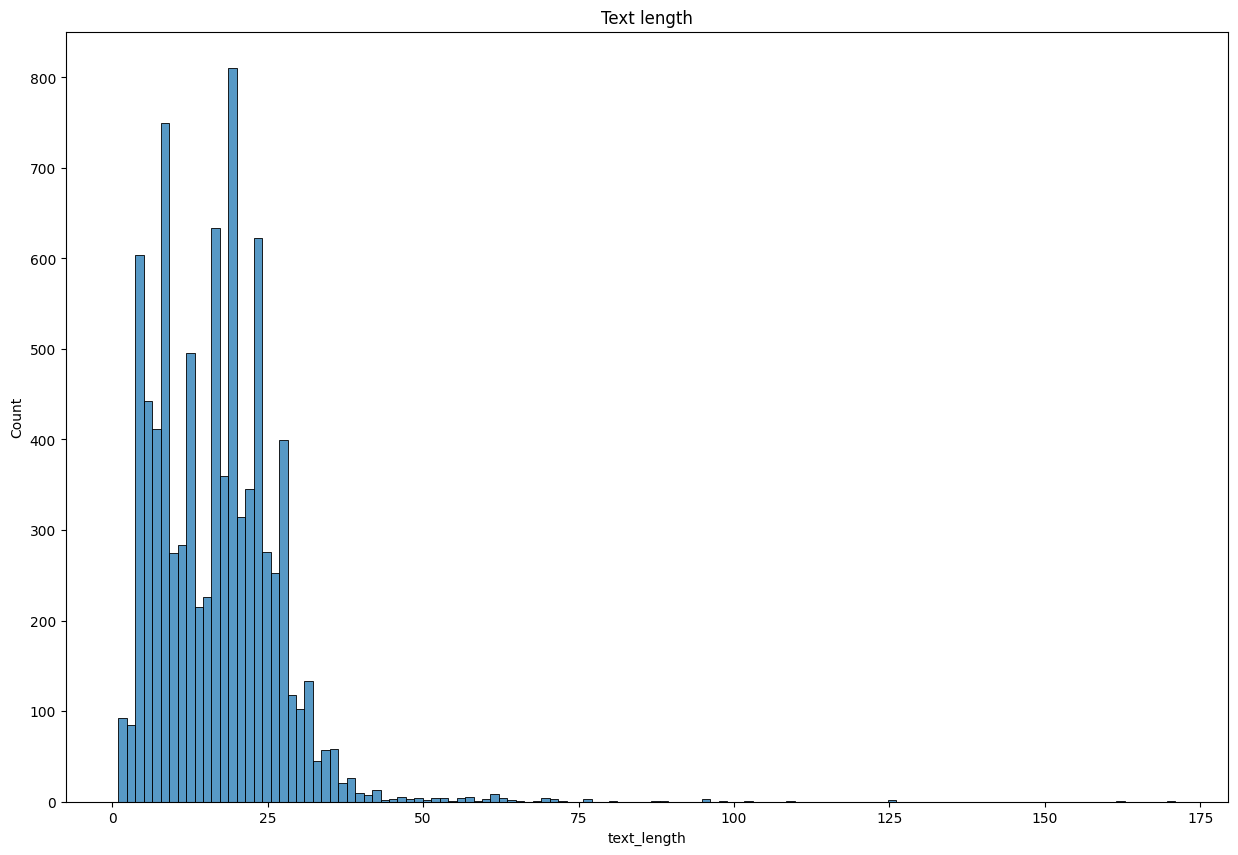

171


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.histplot(data=dataframe['text_length'])
plt.title('Text length')
plt.show()
plt.close()

print(dataframe['text_length'].max())
MAX_TEXT_LENGTH = dataframe['text_length'].max()
NUM_LABELS = 2

# Dataset preparation with tokenizer

In [60]:
train_data, val_data = train_test_split(dataframe, test_size=0.1, random_state=42, stratify=dataframe['label'])
train_data.to_csv(path_or_buf='/kaggle/working/spam_fixed_augmented_train.csv')
val_data.to_csv(path_or_buf='/kaggle/working/spam_fixed_augmented_val.csv')

In [61]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert/distilbert-base-uncased')


def tokenize_data(data, max_length=256):
    texts = data['text'].tolist()
    tokens = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return tokens


train_tokens = tokenize_data(train_data)
val_tokens = tokenize_data(val_data)
print(train_tokens.input_ids.shape)

torch.Size([7704, 256])


In [62]:
train_dataset = TensorDataset(
    train_tokens['input_ids'],
    train_tokens['attention_mask'],
    torch.tensor(train_data['label'].tolist(), dtype=torch.long),
    torch.tensor(train_data['samp_weight'].to_list())
)

val_dataset = TensorDataset(
    val_tokens['input_ids'],
    val_tokens['attention_mask'],
    torch.tensor(val_data['label'].tolist(), dtype=torch.long),
    torch.tensor(val_data['samp_weight'].to_list())
)

In [63]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Load model and train routine

In [64]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [65]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert/distilbert-base-uncased', num_labels=NUM_LABELS).to(DEVICE)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
from tqdm import tqdm
import evaluate

def run_model_on_loader(
        model,
        loader: DataLoader,
        epoch,
        num_epochs,
        optimizer,
        criterion,
        mode,
        device
):
    total_loss = 0
    epoch_mcc = 0
    epoch_f1 = 0
    cumul_mcc = 0
    cumul_f1 = 0
    running_mcc = evaluate.load('matthews_correlation')
    running_f1 = evaluate.load('f1')
    dummy = {
        0 : [1, 0], 
        1 : [0, 1]
    }
    cur_tqdm = tqdm(loader)
    for input_ids, attention_mask, labels, samp_weights in cur_tqdm:
        
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        #print(labels)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        #labels_oh = labels.detach().cpu().apply_(lambda x: torch.tensor(dummy[x])).to(device)
        oh_dum = []
        for el in labels:
            oh_dum.append(dummy[el.item()])
        labels_oh = torch.FloatTensor(oh_dum).to(device)
        outputs_loss = criterion(outputs.logits, labels_oh)
        total_loss += outputs_loss.item()
        
        if mode == 'train':
            optimizer.zero_grad()
            outputs_loss.backward()
            optimizer.step()
        
        gt = torch.argmax(labels_oh, dim=-1)
        results = torch.argmax(outputs.logits, dim=-1)
        res_f1 = running_f1.compute(references=gt, predictions=results, average='weighted', sample_weight=samp_weights.tolist())
        res_mcc = running_mcc.compute(references=gt, predictions=results, sample_weight=samp_weights.tolist())
        
        cumul_mcc += res_mcc['matthews_correlation']
        cumul_f1 += res_f1['f1']
        
        show_dict = {'Loss': f'{outputs_loss.item():.6f}',
                    'F1': f"{res_f1['f1']}",
                    'Matthews_correlation': f"{res_mcc['matthews_correlation']}"}
        cur_tqdm.set_postfix(show_dict)

    loss = total_loss / len(loader)
    epoch_mcc = cumul_mcc / len(loader)
    epoch_f1 = cumul_f1 / len(loader)
    print('='*20)
    print(f'{mode} epoch {epoch + 1}/{num_epochs}: \nLoss: {loss:.4f}\nAccuracy: {epoch_mcc:.4f}\nF1: {epoch_f1:.4f}\n')
    
def train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        criterion,
        device,
        num_epochs=5,
):
    for epoch in range(num_epochs):
        model.train()

        run_model_on_loader(model, train_loader, epoch, num_epochs, optimizer, criterion, mode='train', device=DEVICE)

        model.eval()

        with torch.no_grad():
            run_model_on_loader(model, val_loader, epoch, num_epochs, optimizer, criterion, mode='val', device=DEVICE)

In [67]:
import torch
torch.cuda.empty_cache()

In [68]:
from torch import optim

learning_rate = 5e-5


criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(DEVICE))
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [69]:
train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=5, device=DEVICE)

100%|██████████| 963/963 [02:57<00:00,  5.43it/s, Loss=0.003150, F1=1.0, Matthews_correlation=1.0]                               


train epoch 1/5: 
Loss: 0.0414
Accuracy: 0.9377
F1: 0.9742



100%|██████████| 107/107 [00:07<00:00, 15.25it/s, Loss=0.049276, F1=0.8915873516334141, Matthews_correlation=0.695085750664092]


val epoch 1/5: 
Loss: 0.0180
Accuracy: 0.9753
F1: 0.9923



100%|██████████| 963/963 [02:59<00:00,  5.36it/s, Loss=0.000952, F1=1.0, Matthews_correlation=1.0]                              


train epoch 2/5: 
Loss: 0.0089
Accuracy: 0.9813
F1: 0.9956



100%|██████████| 107/107 [00:06<00:00, 15.33it/s, Loss=0.004703, F1=1.0, Matthews_correlation=0.9999999999999994]              


val epoch 2/5: 
Loss: 0.0134
Accuracy: 0.9714
F1: 0.9899



100%|██████████| 963/963 [02:59<00:00,  5.36it/s, Loss=0.006841, F1=1.0, Matthews_correlation=1.0]                              


train epoch 3/5: 
Loss: 0.0037
Accuracy: 0.9863
F1: 0.9976



100%|██████████| 107/107 [00:06<00:00, 15.35it/s, Loss=0.000169, F1=1.0, Matthews_correlation=0.9999999999999994]              


val epoch 3/5: 
Loss: 0.0148
Accuracy: 0.9799
F1: 0.9941



100%|██████████| 963/963 [02:59<00:00,  5.36it/s, Loss=0.008409, F1=1.0, Matthews_correlation=1.0]                               


train epoch 4/5: 
Loss: 0.0068
Accuracy: 0.9766
F1: 0.9964



100%|██████████| 107/107 [00:06<00:00, 15.35it/s, Loss=0.000508, F1=1.0, Matthews_correlation=0.9999999999999994]              


val epoch 4/5: 
Loss: 0.0203
Accuracy: 0.9664
F1: 0.9872



100%|██████████| 963/963 [02:59<00:00,  5.37it/s, Loss=0.000026, F1=1.0, Matthews_correlation=1.0]                              


train epoch 5/5: 
Loss: 0.0043
Accuracy: 0.9800
F1: 0.9972



100%|██████████| 107/107 [00:06<00:00, 15.34it/s, Loss=0.000016, F1=1.0, Matthews_correlation=0.9999999999999994]              

val epoch 5/5: 
Loss: 0.0093
Accuracy: 0.9841
F1: 0.9965



In [71]:
import os
os.mkdir('/kaggle/working/SpamHamModel')

In [72]:
model.save_pretrained('/kaggle/working/SpamHamModel')